In [35]:
# !pip install pycuda

In [69]:
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
# import pycuda.driver as cuda
import time
import sys
import torch
import torch.nn as nn
import tqdm

from prettytable import PrettyTable
from sklearn.metrics import *
from torch.utils.data import Dataset

In [37]:
# https://medium.com/ai%C2%B3-theory-practice-business/use-gpu-in-your-pytorch-code-676a67faed09
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
__pyTorch VERSION: 2.0.0+cu118
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [38]:
# cuda.init()
# ## Get Id of default device
# torch.cuda.current_device() # Tesla T4 with standard GPU on Google drive
# # 0
# cuda.Device(0).name() # '0' is the id of your GPU

In [70]:
seed = 0
torch.manual_seed(seed)
# seet = 0, 1, 2, -> fails
# seed = 3 -> works

# seed = 3 -> different later?
# Predicted percent of patients that have the condition: 0.3358208955223881
# Actual percent of patients that have the condition: 0.27611940298507465
# Accuracy: 0.8805970149253731
# Precision: 0.7333333333333333
# Recall: 0.8918918918918919
# F1 Score: 0.8048780487804879
# AUC: 0.9166202284758985

# Predicted percent of patients that have the condition: 0.3208955223880597
# Actual percent of patients that have the condition: 0.27611940298507465
# Accuracy: 0.8955223880597015
# Precision: 0.7674418604651163
# Recall: 0.8918918918918919
# F1 Score: 0.825
# AUC: 0.9196851490665925

# Predicted percent of patients that have the condition: 0.31343283582089554
# Actual percent of patients that have the condition: 0.27611940298507465
# Accuracy: 0.9029850746268657
# Precision: 0.7857142857142857
# Recall: 0.8918918918918919
# F1 Score: 0.8354430379746834
# AUC: 0.9281833379771524

In [40]:
# For better printing
torch.set_printoptions(sci_mode=False)

In [41]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [42]:
os.chdir("/content/drive/MyDrive/DLH project")

In [43]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [44]:
labelled_corpus_df = pd.read_csv("labelled_corpus_df.csv", index_col = 0)

In [45]:
labelled_corpus_df.head(1)

,HADM_ID,SUBJECT_ID,Advanced.Cancer,Advanced.Heart.Disease,Advanced.Lung.Disease,Chronic.Neurological.Dystrophies,Chronic.Pain.Fibromyalgia,Alcohol.Abuse,Other.Substance.Abuse,Obesity,Schizophrenia.and.other.Psychiatric.Disorders,Depression,Cleaned Text
0,118003.0,3644,0,0,0,0,1,0,0,0,0,1,admission date 2200 4 7 discharge date 2200 4 ...


In [46]:
# Takes some time (< 1 minute)
study_corpus_tensor = torch.load("embedded_docs.pt")

In [47]:
study_corpus_tensor.shape

torch.Size([1341, 5434, 100])

In [48]:
study_corpus_tensor.device

device(type='cpu')

In [49]:
study_corpus_tensor = study_corpus_tensor.to(device)
print(study_corpus_tensor.device)

cuda:0


In [50]:
embedding_vector_size = study_corpus_tensor.shape[2]
print(embedding_vector_size)

100


In [51]:
class CustomDatasetEmbedded(Dataset):
    def __init__(self, corpus_tensor, labels):
        """
        Store the corpus (of shape num_docs by max_num_words_per_doc by size_of_word embedding) 
        labels (for a single target variable)
        """

        self.x = corpus_tensor
        self.y = labels

    def __len__(self):

        """
        Return the number of documents
        """
        return len(self.y)

    def __getitem__(self, index):
        """
        Return one document (represented as a tensor, with each row being the embedding for one word in that document),
        and its label (whether the patient described has or does not have some phenotype)
        """
        return (self.x[index, :, :], self.y[index])

In [52]:
depression_y = torch.tensor(labelled_corpus_df["Depression"]).to(device)
print(depression_y.device)

cuda:0


In [53]:
depression_dataset = CustomDatasetEmbedded(study_corpus_tensor, depression_y)

In [54]:
train_dataset, test_dataset = torch.utils.data.random_split(depression_dataset, [0.8, 0.2])

In [55]:
len(train_dataset)

1073

In [56]:
len(test_dataset)

268

In [57]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True) # Batch size?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32)

In [58]:
# From a PDF linked to the paper:
# CNN Hyperparameters. We set the number of feature maps for each convolution
# width to 100 and used dropout with a probability of 0.5 to prevent overfitting [1]. All
# parameters were initialized using a uniform distribution from −0.05 to 0.05. The model
# was trained with adadelta [2]. After every parameter update, the parameters of the
# feature maps were normalized to a norm of 3
# I have no idea how to do the normalization, and a TA said it was strange and could be ignored

class CNN_1_gram(nn.Module):
    def __init__(self):
        super(CNN_1_gram, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1,
                               out_channels = 100,
                               kernel_size = (1, embedding_vector_size),
                               stride = 1,
                               padding = 0)
        # torch.nn.init.uniform_(self.conv1.weight, -0.05, 0.05) # Did not help????
        
        # each kernel's feature map is condensed to a single value
        conv1_output_height = study_corpus_tensor.shape[1] + 1 - 1
        self.pool1 = nn.MaxPool2d(kernel_size = (conv1_output_height, 1))

        self.do = nn.Dropout(p = 0.5) 

        self.fc= nn.Linear(100, 2) # Input size. 100, for 100 filters here.
        # torch.nn.init.uniform_(self.fc.weight, -0.05, 0.05) #  # Did not help????

        self.activation = nn.LogSoftmax(dim = 1) # Called on tensor of shape [batch_size, 2]
        
    def forward(self, x):
        # Provided Lua code (last_layer is probably output of pooling):
        # local output = nn.LogSoftMax()(linear(nn.Dropout(opt.dropout_p)(last_layer)))

        # print() 
        # print(x.shape) # torch.Size([32, 5434, 100])
        # raise NotImplementedError

        # Add an extra dimension, because nn.Conv2d takes an input of (batch_size, number of channels, height of input, width of input)
        # and not (batch_size, height of input, width of input)
        x = torch.unsqueeze(x, dim = 1)

        # print() 
        # print(x.shape) # [32, 1, 5434, 100]
        # raise NotImplementedError

        x1 = self.conv1(x)

        # print() 
        # print(x1.shape) # [32, 100, 5434, 1] -> correct. For each of the 32 documents in the batch, we make one output for each word
        # print(x1[0, 0, 0:10, :])
        # raise NotImplementedError

        x1 = torch.relu(x1) # Point of this, given the max pooling?
        # print() 
        # print(x1.shape) # [32, 100, 5434, 1] -> correct. For each of the 32 documents in the batch, we make one output for each word
        # print(x1[0, 0, 0:10, :]) # seems good
        # raise NotImplementedError

        # print()
        # print(self.pool1.kernel_size) # (5434, 100)
        # print(x1.shape) # [32, 100, 5434, 1] -> seems right

        x = self.pool1(x1)
        # print()
        # print(x.shape) # [32, 100, 1, 1]
        # print(x[0, :, :, :]) # Get maximum value from output of each of the 100 filters across whole input, for each of the 32 documents in the batch
        # raise NotImplementedError

        x = self.do(x)
        # print()
        # print(x.shape) # [32, 100, 1, 1]
        # print(x[0, :, :, :]) # as above, but zero out some of the pooled vaues
        # raise NotImplementedError

        x = torch.flatten(x, start_dim = 1) # check that start_dim is right for our input????
        # print()
        # print(x.shape) # [32, 100]
        # print(x[0, :]) # seems right
        # raise NotImplementedError
        
        x = self.fc(x)

        # print()
        # print(x.shape) #[32, 2]
        # print(x)
        # raise NotImplementedError

        x = self.activation(x)

        # print()
        # print(x.shape) #[32, 2]
        # print(x) # Seems to match outputs from previous step. However, in each tuple [first, second], first is usually close to 0, and second is often in the range -10 to -20, or even a bit lower
        # raise NotImplementedError

        # print()
        # print(torch.exp(x)) 
        # raise NotImplementedError

        return x

In [59]:
cnn_1_gram_model = CNN_1_gram().to(device)
print(cnn_1_gram_model)

CNN_1_gram(
  (conv1): Conv2d(1, 100, kernel_size=(1, 100), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(5434, 1), stride=(5434, 1), padding=0, dilation=1, ceil_mode=False)
  (do): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (activation): LogSoftmax(dim=1)
)


In [60]:
# Specified in main.lua within the GitHub repository provided by the authors of the original study
# local criterion = nn.ClassNLLCriterion()
criterion = nn.modules.loss.NLLLoss() # CrossEntropyLoss() doesn't help

# Adadelta specified in a PDF file attached to the original paper
# Hyperparameters for the optimizer are specified in trainer.lua from the GitHub repository provided by the authors of the original study
# config = { rho = 0.95, eps = 1e-6 }
# We saw:
# "cmd:option('-learning_rate', .5, 'Initial Learning Rate')"/"
# in main.lua, but this does not seem to have been used
optimizer = torch.optim.Adadelta(cnn_1_gram_model.parameters(), rho = 0.95, eps = 1e-6)

In [61]:
# From main.lua in the provided code:
# cmd:option('-epochs', 20, 'Number of training epochs')
# 20 is the default
n_epochs = 20

# From HW3 CNN
def train_model(model, train_dataloader, n_epoch, optimizer, criterion):
    """
    :param model: A CNN model
    :param train_dataloader: the DataLoader of the training data
    :param n_epoch: number of epochs to train
    :return:
        model: trained model
    """
    model.train() # prep model for training
    
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        # For testing
        loader_index = 0
        for x, y in tqdm.tqdm(train_dataloader):
            """
            TODO: Within the loop, do the normal training procedures:
                   pass the input through the model
                   pass the output through loss_func to compute the loss (name the variable as *loss*)
                   zero out currently accumulated gradient, use loss.basckward to backprop the gradients, then call optimizer.step
            """

            # print(x.shape) # torch.Size([32, 5434, 100])
            # print(y.shape) # torch.Size([32])
            # raise NotImplementedError

            # your code here
            # FROM HOMEWORK 2
            """ Step 1. clear gradients """
            optimizer.zero_grad()
            """ 
            TODO: Step 2. perform forward pass using `model`, save the output to y_hat;
                  Step 3. calculate the loss using `criterion`, save the output to loss.
            """

            y_hat = model(x)
            loss = criterion(y_hat, y)

            # print(y_hat)
            # print(y)
            # raise NotImplementedError

            """ Step 4. backward pass """
            loss.backward()
            """ Step 5. optimization """
            optimizer.step()
            """ Step 6. record loss """
            curr_epoch_loss.append(loss.cpu().data.numpy())


            # print(torch.sum(torch.max(y_hat, 1).indices) / len(y))
            # if epoch == n_epochs - 1 and loader_index == 0: #and loader_index == 33:
                # print(y_hat)
                # print(y)
                # print(torch.max(y_hat, 1).indices) # NOT RETURNING ALL 0s during training??????
                # print(torch.sum(torch.max(y_hat, 1).indices) / len(y))
            loader_index += 1

        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
    return model

In [62]:
start_time = time.time()
cnn_1_gram_model = train_model(model = cnn_1_gram_model,
                               train_dataloader = train_loader,
                               n_epoch = n_epochs,
                               optimizer = optimizer,
                               criterion = criterion)
end_time = time.time()
print()
print(end_time - start_time)

100%|██████████| 34/34 [00:00<00:00, 65.00it/s]


Epoch 0: curr_epoch_loss=3.6057345867156982


100%|██████████| 34/34 [00:00<00:00, 75.32it/s]


Epoch 1: curr_epoch_loss=1.8929961919784546


100%|██████████| 34/34 [00:00<00:00, 75.78it/s]


Epoch 2: curr_epoch_loss=1.4821358919143677


100%|██████████| 34/34 [00:00<00:00, 75.02it/s]


Epoch 3: curr_epoch_loss=0.9905175566673279


100%|██████████| 34/34 [00:00<00:00, 75.23it/s]


Epoch 4: curr_epoch_loss=0.8785591721534729


100%|██████████| 34/34 [00:00<00:00, 73.70it/s]


Epoch 5: curr_epoch_loss=0.8067871332168579


100%|██████████| 34/34 [00:00<00:00, 74.08it/s]


Epoch 6: curr_epoch_loss=0.7074093818664551


100%|██████████| 34/34 [00:00<00:00, 73.37it/s]


Epoch 7: curr_epoch_loss=0.7342303991317749


100%|██████████| 34/34 [00:00<00:00, 74.46it/s]


Epoch 8: curr_epoch_loss=0.7020488381385803


100%|██████████| 34/34 [00:00<00:00, 73.47it/s]


Epoch 9: curr_epoch_loss=0.7068085074424744


100%|██████████| 34/34 [00:00<00:00, 73.15it/s]


Epoch 10: curr_epoch_loss=0.6865540742874146


100%|██████████| 34/34 [00:00<00:00, 73.75it/s]


Epoch 11: curr_epoch_loss=0.6252948641777039


100%|██████████| 34/34 [00:00<00:00, 73.46it/s]


Epoch 12: curr_epoch_loss=0.6612766981124878


100%|██████████| 34/34 [00:00<00:00, 75.27it/s]


Epoch 13: curr_epoch_loss=0.6194940209388733


100%|██████████| 34/34 [00:00<00:00, 75.70it/s]


Epoch 14: curr_epoch_loss=0.6474758386611938


100%|██████████| 34/34 [00:00<00:00, 74.99it/s]


Epoch 15: curr_epoch_loss=0.6024224162101746


100%|██████████| 34/34 [00:00<00:00, 76.06it/s]


Epoch 16: curr_epoch_loss=0.613248348236084


100%|██████████| 34/34 [00:00<00:00, 75.31it/s]


Epoch 17: curr_epoch_loss=0.5730602741241455


100%|██████████| 34/34 [00:00<00:00, 75.28it/s]


Epoch 18: curr_epoch_loss=0.6274275779724121


100%|██████████| 34/34 [00:00<00:00, 75.70it/s]

Epoch 19: curr_epoch_loss=0.5863437056541443

9.35472059249878


In [63]:
# From HW3 CNN
def eval_model(model, dataloader):
    """
    :return:
        Y_pred: prediction of model on the dataloder. Should be an numpy array of ints
        Y_true: truth labels. Should be an numpy array of ints
    """
    model.eval()
    Y_pred  = []
    Y_true  = []
    Y_score = []
    with torch.no_grad():
        for x, y in dataloader:
            # your code here
            Y_true.append(y)
            
            y_hat = model(x)
            # print(torch.max(y_hat, 1).indices)
            
            Y_score.append(torch.exp(y_hat[:, 1]))

            # print(y_hat[:, 1])
            # print(y)
            # raise NotImplementedError

            # https://campuswire.com/c/G902DEAF1/feed/823
            # Return class with higher probability
            Y_pred.append(torch.max(y_hat, 1).indices)
            
    #         raise NotImplementedError

    Y_score = [y_score.to("cpu") for y_score in Y_score]
    Y_pred  = [y_pred.to("cpu")  for y_pred  in Y_pred]
    Y_true  = [y_true.to("cpu")  for y_true  in Y_true]

    Y_score = np.concatenate(Y_score, axis = 0)    
    Y_pred  = np.concatenate(Y_pred,  axis=0)
    Y_true  = np.concatenate(Y_true,  axis=0)


    return Y_score, Y_pred, Y_true

In [64]:
y_score, y_pred, y_true = eval_model(cnn_1_gram_model, test_loader)

In [65]:
print("Predicted percent of patients that have the condition:", np.sum(y_pred) / len(y_pred))
print("Actual percent of patients that have the condition:", np.sum(y_true) / len(y_true))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("AUC:", roc_auc_score(y_true, y_score))

Predicted percent of patients that have the condition: 0.0
Actual percent of patients that have the condition: 0.30223880597014924
Accuracy: 0.6977611940298507
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
AUC: 0.8853898461741601


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


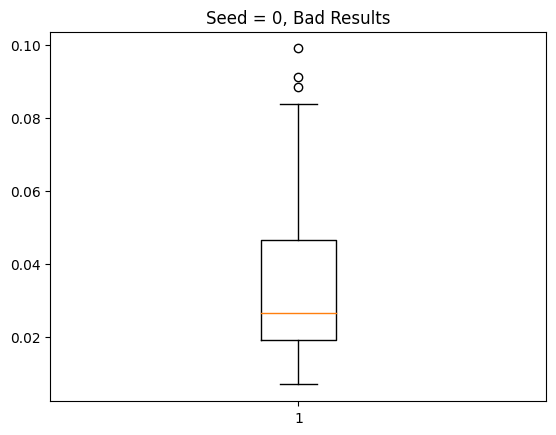

In [66]:
plt.boxplot(y_score)
plt.title("Seed = " + seed)
plt.show()

In [67]:
# for x, y in train_loader:
#     print(torch.sum(y))

In [68]:
# for x, y in test_loader:
#     print(torch.sum(y))

In [71]:
# From https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/23?page=2
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(cnn_1_gram_model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |   10000    |
|  conv1.bias  |    100     |
|  fc.weight   |    200     |
|   fc.bias    |     2      |
+--------------+------------+
Total Trainable Params: 10302


10302